# LSTM Training

In [1]:
import sys
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import os

from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [2]:
# load dataset
dataset = read_csv('../datasets/bss/dublin/reorg/station_2.csv')

dataset = dataset.drop('TIME', axis=1)
values = dataset.values

# ensure all data is float
values = values.astype('float32')

# normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

print(scaled)

[[0.         0.5226481  0.58082193 0.5       ]
 [0.         0.5261324  0.58082193 0.5       ]
 [0.         0.5296167  0.58082193 0.5       ]
 ...
 [0.05       0.9930314  0.         0.8333334 ]
 [0.05       0.9965157  0.         0.8333334 ]
 [0.05       1.         0.         0.8333334 ]]


In [3]:
# split into train and test sets

# Manually setting train and test sets
train_start = 0
train_end = 8760

test_start = 99144
test_end = 108071

n_train_hours = 365 * 24
train = scaled[train_start:train_end, :]
test = scaled[test_start:test_end, :]

# split into input and outputs
train_X, train_y = train[:, 1:], train[:, 0]
test_X, test_y = test[:, 1:], test[:, 0]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 3) (8760,) (8927, 1, 3) (8927,)


In [4]:
# design network
model = Sequential()
model.add(LSTM(40, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error')

# fit network
history = model.fit(train_X, train_y,
                    epochs=150,
                    batch_size=64,
                    validation_data=(test_X, test_y),
                    verbose=2,
                    shuffle=False)


Epoch 1/150
137/137 - 6s - loss: 0.0901 - val_loss: 0.0753
Epoch 2/150
137/137 - 0s - loss: 0.0816 - val_loss: 0.0754
Epoch 3/150
137/137 - 0s - loss: 0.0803 - val_loss: 0.0755
Epoch 4/150
137/137 - 0s - loss: 0.0795 - val_loss: 0.0757
Epoch 5/150
137/137 - 0s - loss: 0.0790 - val_loss: 0.0759
Epoch 6/150
137/137 - 0s - loss: 0.0786 - val_loss: 0.0760
Epoch 7/150
137/137 - 0s - loss: 0.0783 - val_loss: 0.0761
Epoch 8/150
137/137 - 0s - loss: 0.0781 - val_loss: 0.0761
Epoch 9/150
137/137 - 0s - loss: 0.0778 - val_loss: 0.0761
Epoch 10/150
137/137 - 0s - loss: 0.0776 - val_loss: 0.0760
Epoch 11/150
137/137 - 0s - loss: 0.0774 - val_loss: 0.0760
Epoch 12/150
137/137 - 0s - loss: 0.0772 - val_loss: 0.0758
Epoch 13/150
137/137 - 0s - loss: 0.0770 - val_loss: 0.0757
Epoch 14/150
137/137 - 0s - loss: 0.0767 - val_loss: 0.0755
Epoch 15/150
137/137 - 0s - loss: 0.0764 - val_loss: 0.0753
Epoch 16/150
137/137 - 0s - loss: 0.0762 - val_loss: 0.0751
Epoch 17/150
137/137 - 0s - loss: 0.0759 - val_lo

137/137 - 0s - loss: 0.0467 - val_loss: 0.0473
Epoch 138/150
137/137 - 0s - loss: 0.0467 - val_loss: 0.0472
Epoch 139/150
137/137 - 0s - loss: 0.0467 - val_loss: 0.0472
Epoch 140/150
137/137 - 0s - loss: 0.0467 - val_loss: 0.0472
Epoch 141/150
137/137 - 0s - loss: 0.0466 - val_loss: 0.0471
Epoch 142/150
137/137 - 0s - loss: 0.0466 - val_loss: 0.0471
Epoch 143/150
137/137 - 1s - loss: 0.0466 - val_loss: 0.0471
Epoch 144/150
137/137 - 0s - loss: 0.0466 - val_loss: 0.0470
Epoch 145/150
137/137 - 0s - loss: 0.0466 - val_loss: 0.0470
Epoch 146/150
137/137 - 0s - loss: 0.0466 - val_loss: 0.0470
Epoch 147/150
137/137 - 0s - loss: 0.0466 - val_loss: 0.0470
Epoch 148/150
137/137 - 0s - loss: 0.0466 - val_loss: 0.0469
Epoch 149/150
137/137 - 0s - loss: 0.0466 - val_loss: 0.0469
Epoch 150/150
137/137 - 0s - loss: 0.0466 - val_loss: 0.0469


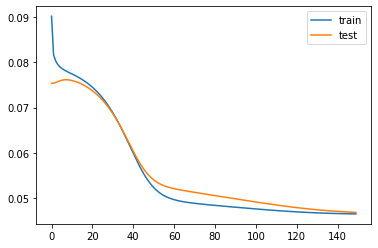

In [5]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 40)                7040      
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
Total params: 7,081
Trainable params: 7,081
Non-trainable params: 0
_________________________________________________________________


In [7]:
# make a bunch of predictions
yhat = model.predict(test_X)

test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

# Print metrics
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
mse = mean_squared_error(inv_y, inv_yhat)
r2 = r2_score(inv_y, inv_yhat)

print('Test MAE: %.3f' % mae)
print('Test MSE: %.3f' % mse)
print('Test RMSE: %.3f' % rmse)
print('Test R2: %.30f' % r2)



Test MAE: 3.388
Test MSE: 18.760
Test RMSE: 4.331
Test R2: 0.364856978743034798817745922861
